In [77]:
import calendar
import logging
import os
from pathlib import Path
import datetime as dt

import numpyro
import pandas as pd
import torch
import xarray as xr
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    geom_point,
    facet_wrap,
    geom_vline,
    guides,
    ggplot,
    facet_grid,
    scale_x_datetime,
    geom_ribbon,
    theme,
    theme_bw,
    ylab,
    element_text,
    scale_color_brewer,
    geom_hline,
    geom_smooth,
    xlab,
    geom_boxplot,
    scale_x_continuous,
    element_blank,
    guide_legend
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import kernels
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.data_loading.data_loading import load_data
from src.modeling.ensemble import DefaultEnsemble, BoostedRegressor, RandomForest
from src.modeling.gaussian_process import SklearnGPModel, MultitaskGP
from src.modeling.lm import LinearModel
from src.modeling.metrics import summarize
from src.modeling.var_models import VAR, NARX
from src.preprocessing.preprocessing import XArrayStandardScaler, SeasonalFeatures, XArrayFeatureUnion
from src.utils import flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

pd.options.display.float_format = "{:,.3f}".format


In [78]:
def rename_lakes(x):
    return {"eri": "Erie", "sup": "Superior", "mic_hur": "Michigan/Huron", "ont": "Ontario"}.get(x, x)


lake_data = (load_data(["rnbs", "precip", "temp", "evap"]).
             sel(type="Basin").
             dropna("Date").
             to_array().
             transpose("Date", "lake", ...)
             )
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4)> Size: 49kB
array([[[-20.92372 ,  13.33    , 258.3     ,  57.94    ],
        [ 40.5714  ,  23.25    , 263.25    ,  44.87    ],
        [ 93.83467 ,  24.8     , 266.2     ,  29.08    ],
        [239.5306  ,  42.78    , 266.3     ,  40.95    ]],

       [[ 33.66357 ,  16.8     , 258.4     ,  34.3     ],
        [ 39.75065 ,  12.46    , 261.2     ,  34.05    ],
        [145.7005  ,  14.56    , 263.9     ,  24.95    ],
        [ 92.36002 ,  16.8     , 261.1     ,  35.42    ]],

       [[139.9274  ,  35.03    , 267.1     ,  35.06    ],
        [234.0305  ,  34.1     , 270.85    ,  29.745   ],
        [278.341   ,  28.21    , 274.2     ,  29.88    ],
        [446.8436  ,  22.32    , 274.2     ,  32.27    ]],

       ...,

       [[-34.00105 ,  19.84    , 280.5     ,  53.57    ],
        [-47.44791 ,  16.12    , 283.1     ,  60.25    ],
        [-45.33585 ,  18.29    , 285.3     ,  55.55    ],
        [116.2634  ,  23.25    , 283.6     ,  62.46    ]],

       [[  3.796643,  25.2     , 274.1     ,  54.42    ],
        [-13.97484 ,  18.75    , 276.65    ,  50.175   ],
        [-10.20312 ,  27.6     , 278.5     ,  37.59    ],
        [142.3357  ,  26.7     , 277.3     ,  45.81    ]],

       [[-53.29011 ,  13.64    , 266.5     ,  59.74    ],
        [ -2.97982 ,  17.67    , 269.      ,  57.455   ],
        [  0.      ,  16.12    , 269.9     ,  42.62    ],
        [173.6947  ,  28.83    , 269.4     ,  53.72    ]]])
Coordinates:
  * Date      (Date) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 32B 'sup' 'mic_hur' 'eri' 'ont'
    type      <U5 20B 'Basin'
  * variable  (variable) object 32B 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [79]:
num_splits = 5
forecast_steps = 13

test_data = lake_data.sel(Date=slice("2006", "2010"))
train_data = lake_data.sel(Date=slice(None, "2005"))

splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps, gap=0)
splits = list(splitter.split(train_data))

X, y = train_data.sel(variable=["precip", "temp", "evap"]).drop_vars("type"), train_data.sel(
    variable=["rnbs"]).squeeze().drop_vars(
    ["type", "variable"])
test_x, test_y = test_data.sel(variable=["precip", "temp", "evap"]).drop_vars("type"), test_data.sel(
    variable=["rnbs"]).squeeze().drop_vars(
    ["type", "variable"])

y_scaler = XArrayStandardScaler()
y = y_scaler.fit_transform(y)
test_y = y_scaler.transform(test_y)
for train, test in splits:
    # print(X.indexes["Date"][train], X.indexes["Date"][test])
    print(len(train), X.indexes["Date"][test])


259 DatetimeIndex(['2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01',
               '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01',
               '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01',
               '2001-08-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
272 DatetimeIndex(['2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
285 DatetimeIndex(['2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01',
               '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
298 DatetimeIndex(['2003-11-01', '2003-12-01', '2004-01-01', '2004-02-01'

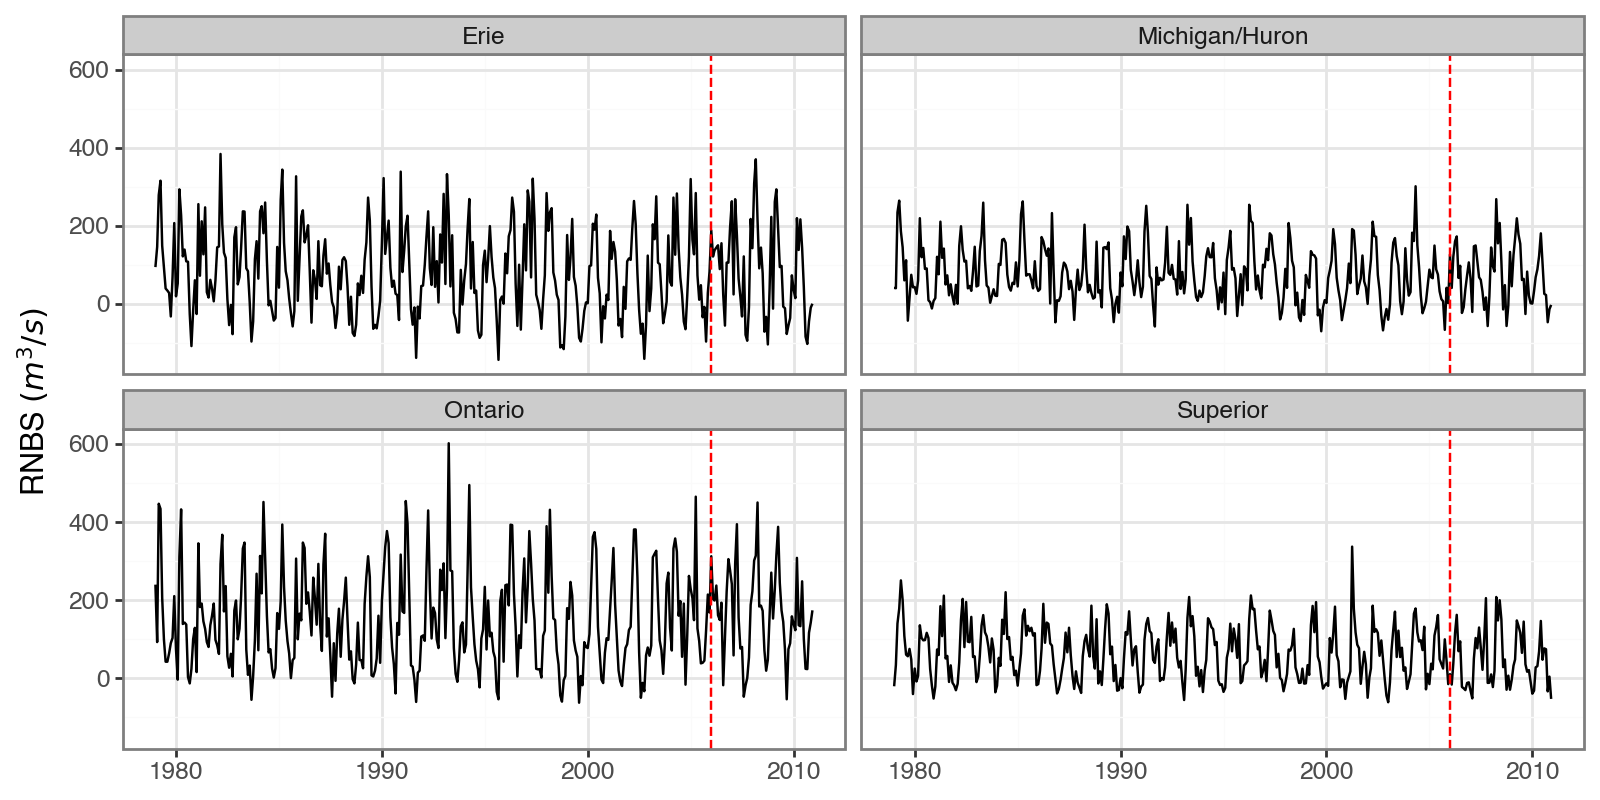

In [107]:
plot_data = lake_data.sel(variable="rnbs").drop_vars(["variable", "type"]).to_dataframe(name="rnbs").reset_index()

(
        ggplot(data=plot_data, mapping=aes(x="Date", y="rnbs")) +
        geom_line() +
        facet_wrap("~lake", labeller=rename_lakes) +
        theme_bw() +
        theme(axis_title_x=element_blank(), figure_size=(8, 4)) +
        scale_x_datetime(labels=date_format(fmt="%Y")) +
        ylab("RNBS $\\left(m^3/s\\right)$") +
        geom_vline(xintercept=dt.datetime(2006, 1, 1), linetype='--', color='red')
)

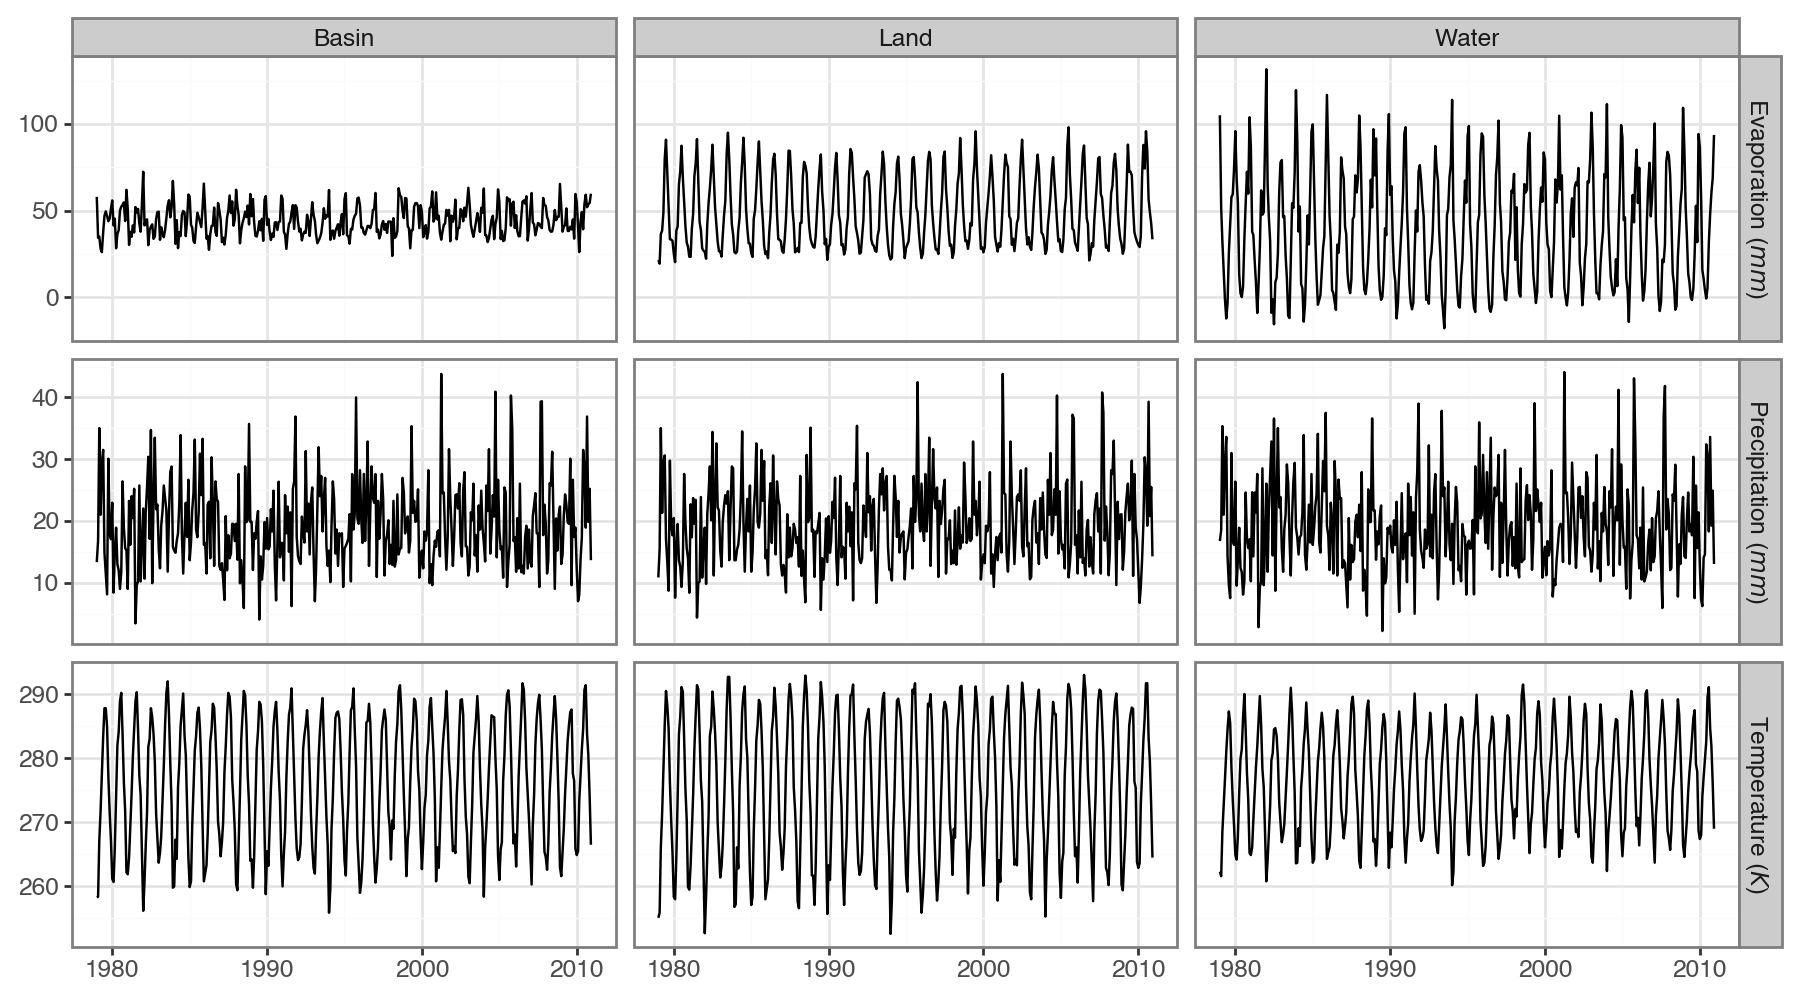

In [112]:
covar_data = (load_data(["precip", "temp", "evap"]).
              to_array().
              sel(type=["Basin", "Land", "Water"], lake="sup").
              # drop_vars("lake").
              dropna("Date").
              transpose("Date", ...)
              )

plot_data = covar_data.to_dataframe(dim_order=["Date", "type", "variable"], name="covar").reset_index()

(

        ggplot(data=plot_data, mapping=aes(x="Date", y="covar")) +
        geom_line() +
        facet_grid("variable~type", scales="free_y",
                   labeller=lambda x: {"evap": "Evaporation ($mm$)", "precip": "Precipitation ($mm$)",
                                       "temp": "Temperature ($K$)"}.get(x, x)) +
        theme_bw() +
        theme(axis_title=element_blank(), figure_size=(9, 5)) +
        scale_x_datetime(labels=date_format(fmt="%Y"))
)


In [82]:
preprocessor = XArrayFeatureUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayStandardScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

gp_models = {
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "MultitaskGP": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", MultitaskGP(epochs=100, rank=1))
    ]),
}

simple_models = {
    "SimpleLM": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LinearModel())
    ]),
    "RF": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForest())
    ]),
    "BoostedTrees": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", BoostedRegressor(n_estimators=500, learning_rate=0.1))
    ]),
}

varx_models = {
    "NARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            NARX(lags={"y": 3, "temp": 0, "precip": 0, "evap": 0}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip": 0, "temp": 0, "evap": 0}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),

}

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    **simple_models,
    **gp_models,
    **varx_models,
}



In [83]:
# run cross validation
results = []
overwrite = False
results_dir = Path("../../_scratch/results")
results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        prediction_file = (results_dir / f"{name}_{i}.csv")
        if prediction_file.exists() and not overwrite:
            logging.info(f"Loading {name} model (split {i + 1}/{num_splits})")
            predictions = pd.read_csv(prediction_file).assign(split=i + 1)
            predictions["Date"] = pd.to_datetime(predictions["Date"])
        else:
            logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
            model.fit(X[train_id], y[train_id])
            preds = model.predict(X[:max(test_id) + 1], y=y[:max(test_id) + 1], forecast_steps=forecast_steps)

            array = xr.concat([
                preds,
                y[test_id].expand_dims({"value": ["true"]}, axis=-1)
            ], dim="value")

            predictions = pd.concat([
                arr.to_pandas().assign(months_ahead=list(range(1, forecast_steps + 1)), model=name)
                for arr in array.transpose("lake", ...)
            ], axis=0, keys=preds.lake.values, names=["lake"]).assign(split=i + 1)
            predictions.to_csv(prediction_file)
        results.append(predictions)

cv_results = pd.concat(results, axis=0)
cv_results.head()

INFO:root:Fitting Default model...
INFO:root:Loading Default model (split 1/5)
INFO:root:Loading Default model (split 2/5)
INFO:root:Loading Default model (split 3/5)
INFO:root:Loading Default model (split 4/5)
INFO:root:Loading Default model (split 5/5)
INFO:root:Fitting SimpleLM model...
INFO:root:Loading SimpleLM model (split 1/5)
INFO:root:Loading SimpleLM model (split 2/5)
INFO:root:Loading SimpleLM model (split 3/5)
INFO:root:Loading SimpleLM model (split 4/5)
INFO:root:Loading SimpleLM model (split 5/5)
INFO:root:Fitting RF model...
INFO:root:Loading RF model (split 1/5)
INFO:root:Loading RF model (split 2/5)
INFO:root:Loading RF model (split 3/5)
INFO:root:Loading RF model (split 4/5)
INFO:root:Loading RF model (split 5/5)
INFO:root:Fitting BoostedTrees model...
INFO:root:Loading BoostedTrees model (split 1/5)
INFO:root:Loading BoostedTrees model (split 2/5)
INFO:root:Loading BoostedTrees model (split 3/5)
INFO:root:Loading BoostedTrees model (split 4/5)
INFO:root:Loading Boost

,lake,Date,mean,lower,upper,std,true,months_ahead,model,split
0,sup,2000-08-01,0.267,-0.651,1.309,0.558,-0.299,1,Default,1
1,sup,2000-09-01,-0.130,-1.088,0.935,0.599,-1.268,2,Default,1
2,sup,2000-10-01,-0.187,-1.215,1.221,0.705,-0.974,3,Default,1
3,sup,2000-11-01,-0.591,-1.357,1.009,0.713,-0.991,4,Default,1
4,sup,2000-12-01,-1.093,-1.605,-0.201,0.402,-1.702,5,Default,1


In [84]:
cv_results_12 = cv_results[cv_results["months_ahead"] <= 12].reset_index()
cv_results_12.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse   mae   mape  variance   bias  coverage  \
lake    model                                                        
eri     BoostedTrees 0.478 0.380  1.753     0.226  0.048     0.917   
        Default      0.632 0.517  1.926     0.393  0.076     0.933   
        GP_Matern    0.407 0.321  8.720     0.162  0.059     0.967   
        MultitaskGP  0.425 0.337 66.075     0.176  0.066     0.950   
        NARX         0.470 0.375  2.049     0.214  0.083     0.883   
        RF           0.511 0.404  1.635     0.260  0.031     0.917   
        SimpleLM     0.467 0.347  2.502     0.213  0.071     0.900   
        VARX         0.459 0.343  1.213     0.206  0.069     0.883   
mic_hur BoostedTrees 0.438 0.367  3.378     0.186  0.078     0.783   
        Default      0.678 0.535  1.476     0.443  0.128     0.917   
        GP_Matern    0.337 0.279  0.701     0.103  0.100     0.983   
        MultitaskGP  0.360 0.297  0.900     0.118  0.110     0.983   
        NARX         0.386 0.282  1.167     0.137  0.106     0.900   
        RF           0.556 0.451  1.911     0.293  0.125     0.900   
        SimpleLM     0.355 0.282 10.043     0.122  0.067     0.967   
        VARX         0.340 0.257  1.018     0.114  0.044     0.917   
ont     BoostedTrees 0.444 0.357  1.011     0.197 -0.011     0.767   
        Default      0.580 0.487 12.297     0.336 -0.027     0.950   
        GP_Matern    0.428 0.340  1.034     0.179  0.068     0.933   
        MultitaskGP  0.409 0.321  1.221     0.165  0.050     0.950   
        NARX         0.429 0.332  1.414     0.175  0.096     0.917   
        RF           0.519 0.410  1.236     0.267 -0.051     0.950   
        SimpleLM     0.491 0.394  1.706     0.239  0.045     0.917   
        VARX         0.439 0.337  1.913     0.185  0.085     0.867   
sup     BoostedTrees 0.487 0.331  0.762     0.232  0.067     0.850   
        Default      0.632 0.460  1.259     0.397  0.052     0.900   
        GP_Matern    0.414 0.313  0.702     0.161  0.103     0.933   
        MultitaskGP  0.458 0.344  0.849     0.201  0.096     0.950   
        NARX         0.449 0.332  0.796     0.194  0.088     0.867   
        RF           0.530 0.353  1.755     0.277  0.063     0.900   
        SimpleLM     0.424 0.311  1.857     0.173  0.080     0.933   
        VARX         0.374 0.291  1.140     0.138  0.042     0.900   

                      interval_len  crps      N    r2  
lake    model                                          
eri     BoostedTrees         2.016 0.264 60.000 0.606  
        Default              2.256 0.360 60.000 0.260  
        GP_Matern            1.578 0.229 60.000 0.762  
        MultitaskGP          1.739 0.239 60.000 0.740  
        NARX                 1.602 0.264 60.000 0.690  
        RF                   1.994 0.291 60.000 0.512  
        SimpleLM             1.733 0.257 60.000 0.707  
        VARX                 1.532 0.254 60.000 0.727  
mic_hur BoostedTrees         1.823 0.255 60.000 0.730  
        Default              2.177 0.381 60.000 0.197  
        GP_Matern            1.578 0.194 60.000 0.870  
        MultitaskGP          1.493 0.204 60.000 0.839  
        NARX                 1.368 0.210 60.000 0.835  
        RF                   1.981 0.316 60.000 0.467  
        SimpleLM             1.427 0.199 60.000 0.865  
        VARX                 1.193 0.188 60.000 0.887  
ont     BoostedTrees         1.621 0.252 60.000 0.723  
        Default              2.177 0.334 60.000 0.434  
        GP_Matern            1.578 0.235 60.000 0.783  
        MultitaskGP          1.700 0.226 60.000 0.792  
        NARX                 1.432 0.238 60.000 0.773  
        RF                   1.895 0.288 60.000 0.552  
        SimpleLM             1.738 0.280 60.000 0.714  
        VARX                 1.386 0.244 60.000 0.773  
sup     BoostedTrees         2.423 0.261 60.000 0.681  
        Default              1.970 0.329 60.000 0.401  
        GP_Matern            1.578 0.223 60.000 0.813  
        Multitask

In [85]:
cv_results_12.groupby(["model"]).apply(summarize, include_groups=False)

,rmse,mae,mape,variance,bias,coverage,interval_len,crps,N,r2
model,,,,,,,,,,
BoostedTrees,0.462,0.359,1.726,0.211,0.046,0.829,1.971,0.258,240.000,0.689
Default,0.631,0.500,4.239,0.395,0.057,0.925,2.145,0.351,240.000,0.328
GP_Matern,0.398,0.313,2.789,0.152,0.083,0.954,1.578,0.220,240.000,0.810
MultitaskGP,0.415,0.325,17.261,0.166,0.080,0.958,1.614,0.227,240.000,0.784
NARX,0.434,0.330,1.356,0.180,0.093,0.892,1.437,0.239,240.000,0.780
RF,0.529,0.404,1.634,0.278,0.042,0.917,1.968,0.292,240.000,0.527
SimpleLM,0.437,0.334,4.027,0.187,0.066,0.929,1.595,0.241,240.000,0.777
VARX,0.406,0.307,1.321,0.161,0.060,0.892,1.337,0.223,240.000,0.819


In [86]:
cv_results_12[cv_results_12["months_ahead"].isin([1, 3, 6, 12])].groupby(["months_ahead", "model"]).apply(summarize,
                                                                                                          include_groups=False)

rmse   mae  mape  variance   bias  coverage  \
months_ahead model                                                       
1            BoostedTrees 0.458 0.371 1.684     0.128  0.286     0.700   
             Default      0.674 0.549 4.713     0.455  0.015     0.900   
             GP_Matern    0.416 0.336 0.752     0.148  0.157     0.950   
             MultitaskGP  0.413 0.324 0.666     0.139  0.177     0.950   
             NARX         0.451 0.354 0.832     0.190  0.114     0.800   
             RF           0.571 0.509 2.701     0.281  0.212     0.950   
             SimpleLM     0.527 0.439 5.007     0.274  0.065     0.850   
             VARX         0.486 0.411 0.973     0.226  0.102     0.750   
3            BoostedTrees 0.353 0.295 1.104     0.116  0.092     0.850   
             Default      0.468 0.419 8.226     0.205  0.118     1.000   
             GP_Matern    0.313 0.270 1.162     0.090  0.091     1.000   
             MultitaskGP  0.299 0.263 1.885     0.084  0.077     1.000   
             NARX         0.543 0.419 1.981     0.229  0.258     0.800   
             RF           0.370 0.301 1.279     0.128  0.094     0.950   
             SimpleLM     0.343 0.266 1.412     0.118  0.017     1.000   
             VARX         0.360 0.289 1.307     0.128  0.041     0.950   
6            BoostedTrees 0.289 0.252 1.627     0.079 -0.068     0.950   
             Default      0.463 0.360 2.481     0.161  0.232     1.000   
             GP_Matern    0.271 0.229 1.201     0.064  0.098     1.000   
             MultitaskGP  0.260 0.222 1.716     0.059  0.092     1.000   
             NARX         0.271 0.220 0.791     0.073  0.008     1.000   
             RF           0.424 0.335 1.173     0.177 -0.050     1.000   
             SimpleLM     0.311 0.273 0.913     0.084  0.114     1.000   
             VARX         0.227 0.191 0.697     0.051  0.034     1.000   
12           BoostedTrees 0.547 0.448 1.287     0.120  0.423     0.800   
             Default      0.542 0.453 1.639     0.261  0.183     0.950   
             GP_Matern    0.453 0.392 1.935     0.073  0.363     0.950   
             MultitaskGP  0.457 0.403 1.932     0.075  0.365     1.000   
             NARX         0.518 0.443 2.515     0.098  0.413     0.800   
             RF           0.555 0.471 1.472     0.177  0.363     0.950   
             SimpleLM     0.459 0.332 1.979     0.114  0.312     0.900   
             VARX         0.483 0.389 2.976     0.119  0.338     0.800   

                           interval_len  crps      N     r2  
months_ahead model                                           
1            BoostedTrees         2.230 0.265 20.000  0.582  
             Default              2.145 0.387 20.000 -1.775  
             GP_Matern            1.593 0.238 20.000  0.687  
             MultitaskGP          1.649 0.232 20.000  0.693  
             NARX                 1.351 0.252 20.000  0.713  
             RF                   2.105 0.344 20.000  0.068  
             SimpleLM             1.596 0.309 20.000  0.415  
             VARX                 1.292 0.284 20.000  0.643  
3            BoostedTrees         1.953 0.217 20.000  0.691  
             Default              2.180 0.279 20.000 -0.124  
             GP_Matern            1.524 0.180 20.000  0.785  
             MultitaskGP          1.521 0.173 20.000  0.797  
             NARX                 1.389 0.307 20.000  0.625  
             RF                   1.955 0.228 20.000  0.590  
             SimpleLM             1.595 0.194 20.000  0.759  
             VARX                 1.317 0.203 20.000  0.779  
6            BoostedTrees         1.864 0.178 20.000  0.812  
             Default              2.214 0.266 20.000  0.634  
             GP_Matern            1.520 0.160 20.000  0.856  
             MultitaskGP          1.515 0.155 20.000  0.871  
             NARX                 1.408 0.162 20.000  0.866  
             RF                   1.956 0.243 20.000  0.606  
             SimpleLM 

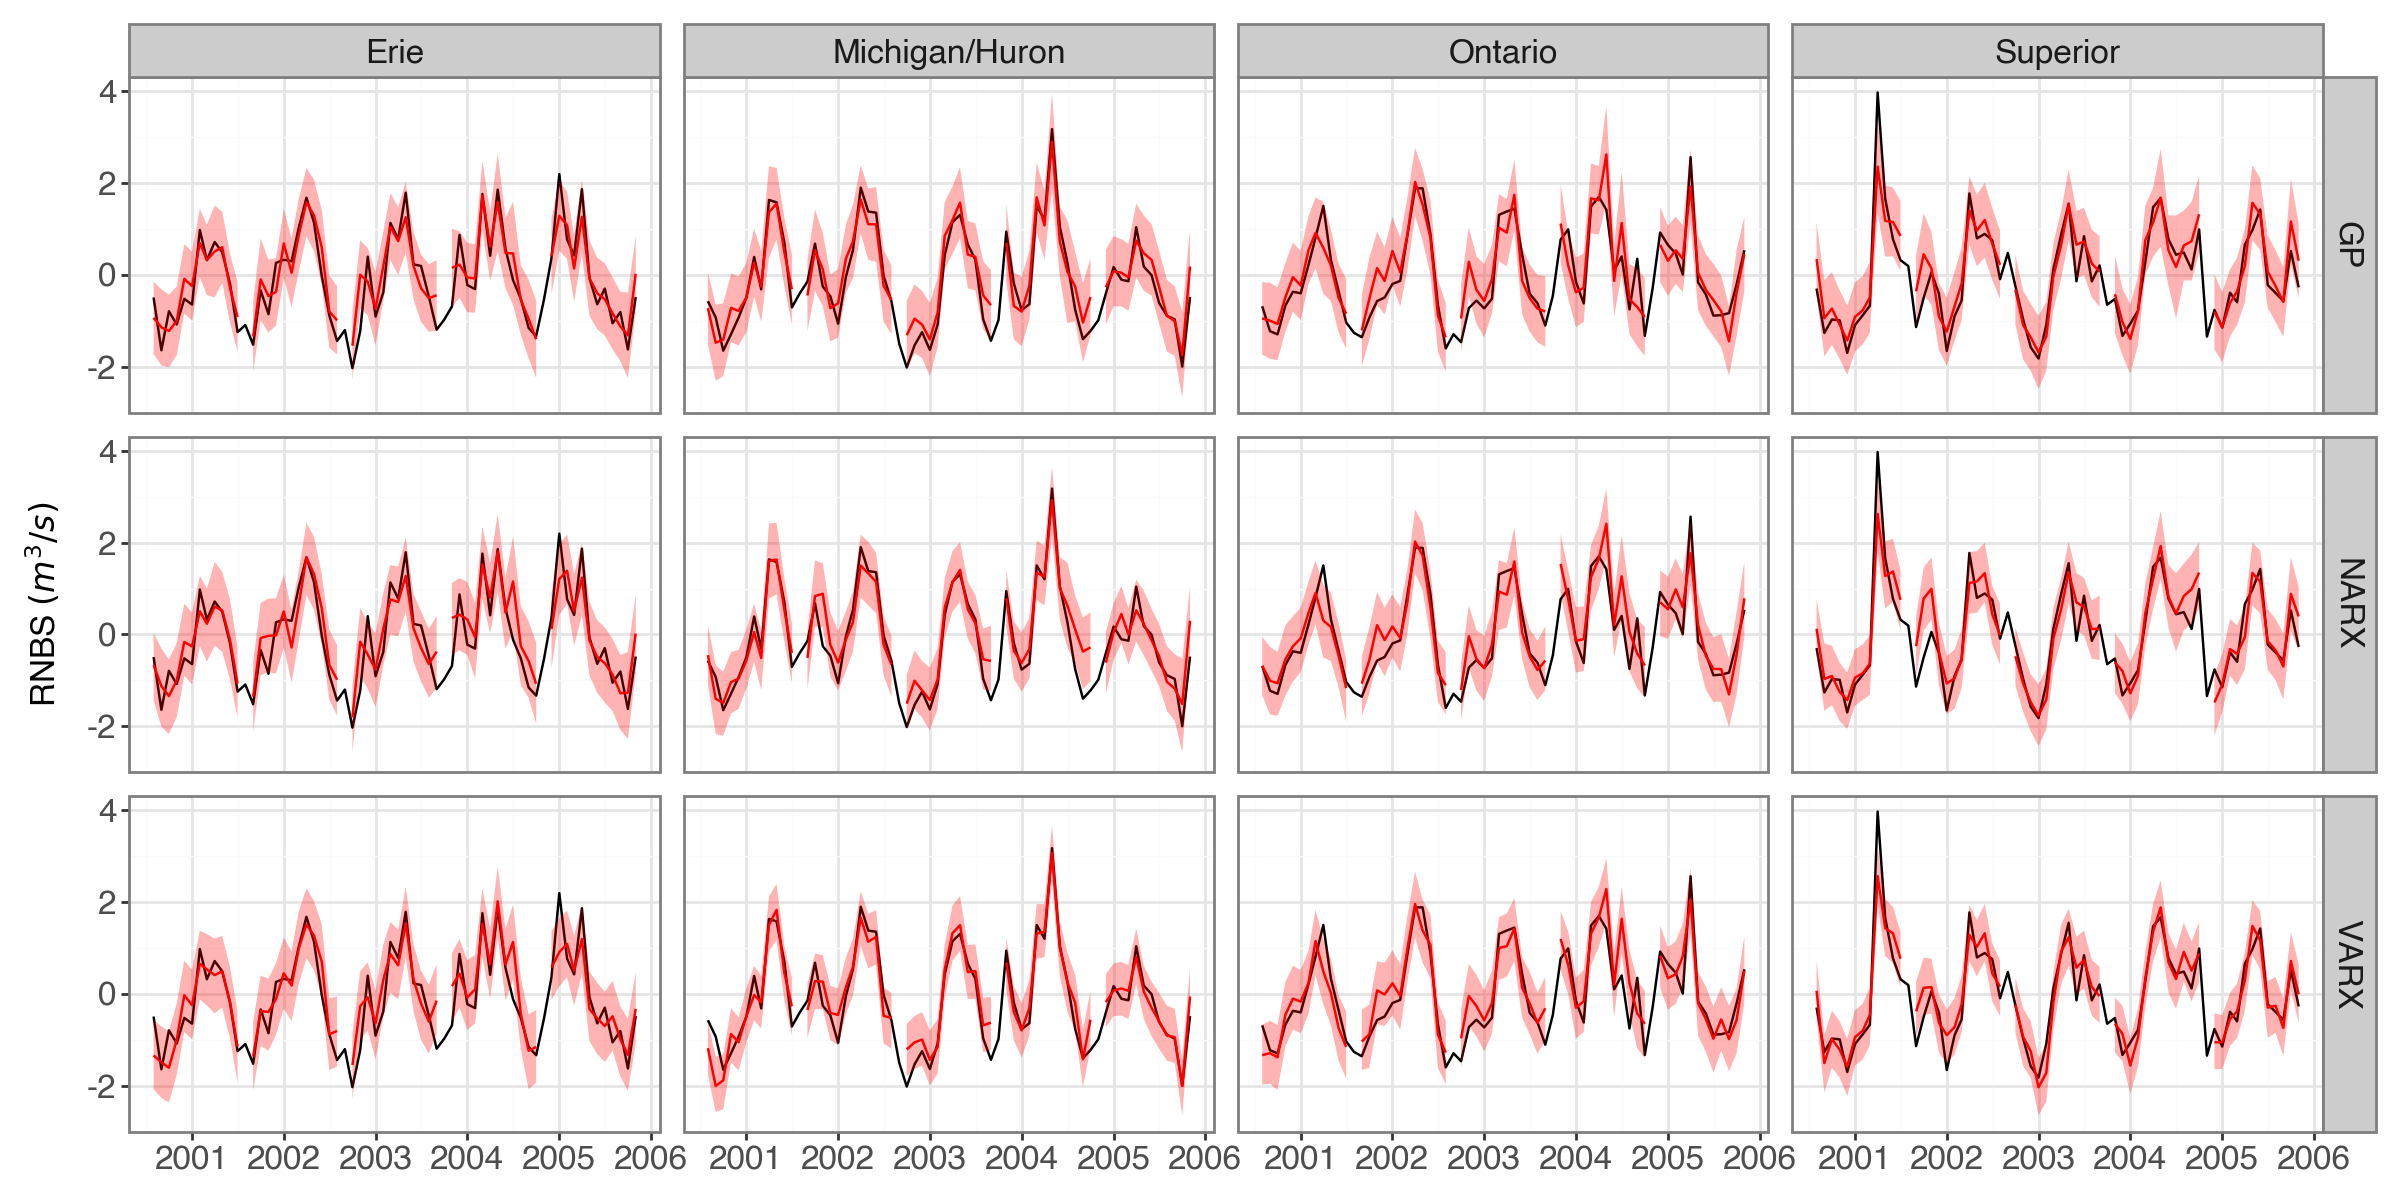

In [115]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results_12[cv_results_12["split"] <= 6].reset_index()
plot_data = plot_data[plot_data["model"].isin(["GP_Matern", "VARX", "NARX"])]


def facet_rename(x):
    labels = {"eri": "Erie", "sup": "Superior", "mic_hur": "Michigan/Huron", "ont": "Ontario", "GP_Matern": "GP"}
    return labels.get(x, x)


(
        ggplot(data=plot_data, mapping=aes(x="Date", y="mean", group="split"))
        + geom_line(data=y.to_dataframe(name="rnbs").reset_index(), mapping=aes(x="Date", y="rnbs"), color="black",
                    inherit_aes=False)
        + geom_line(color="red")
        + facet_grid("model~lake", labeller=facet_rename)
        + scale_x_datetime(
    limits=[plot_data.Date.min(), plot_data.Date.max()],
    labels=date_format(fmt="%Y"), breaks=date_breaks("1 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), alpha=0.3, fill="red"
) + ylab("RNBS $\\left(m^3/s\\right)$")
        + theme_bw()
        + theme(text=element_text(size=12), figure_size=(12, 6), axis_title_x=element_blank())
)


In [16]:
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month, cv_results_12["Date"].dt.month_name()]).apply(
    summarize)

,,rmse,mae,mape,variance,bias,coverage,interval_len,crps,N,r2
Date,Date,,,,,,,,,,
1,January,0.475,0.353,1.564,0.216,0.102,0.875,1.606,0.255,160.000,0.530
2,February,0.347,0.283,2.518,0.114,0.082,0.988,1.627,0.198,160.000,0.650
3,March,0.333,0.266,4.351,0.107,0.063,0.981,1.724,0.192,160.000,0.711
4,April,0.631,0.427,0.558,0.286,-0.335,0.869,1.798,0.320,160.000,-0.580
5,May,0.479,0.352,0.589,0.226,-0.062,0.931,1.828,0.252,160.000,0.505
6,June,0.377,0.294,2.064,0.142,0.005,0.931,1.625,0.214,160.000,0.537
7,July,0.402,0.309,1.894,0.157,0.069,0.944,1.640,0.221,160.000,0.604
8,August,0.380,0.305,1.442,0.118,0.164,0.956,1.573,0.217,160.000,0.457
9,September,0.557,0.447,1.327,0.284,0.161,0.800,1.749,0.320,160.000,-0.252


In [17]:
cv_results_12.groupby(["months_ahead", cv_results_12["model"]]).apply(summarize)
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month_name(), cv_results_12["model"]]).apply(
    summarize)


rmse   mae  mape  variance   bias  coverage  \
Date      model                                                       
April     BoostedTrees 0.652 0.438 0.459     0.260 -0.407     0.650   
          Default      0.814 0.544 0.465     0.630 -0.179     0.950   
          GP_Matern    0.515 0.369 0.433     0.156 -0.331     0.950   
          MultitaskGP  0.626 0.421 0.587     0.261 -0.361     0.950   
          NARX         0.562 0.412 1.111     0.190 -0.354     0.800   
...                      ...   ...   ...       ...    ...       ...   
September MultitaskGP  0.484 0.407 1.207     0.224  0.100     0.900   
          NARX         0.574 0.501 0.931     0.288  0.203     0.700   
          RF           0.684 0.551 3.026     0.387  0.286     0.850   
          SimpleLM     0.537 0.403 0.989     0.267  0.147     0.800   
          VARX         0.514 0.384 1.172     0.261  0.062     0.700   

                        interval_len  crps      N      r2  
Date      model                                            
April     BoostedTrees         1.977 0.317 20.000  -0.997  
          Default              2.426 0.413 20.000 -10.459  
          GP_Matern            1.613 0.265 20.000   0.138  
          MultitaskGP          1.675 0.306 20.000  -0.356  
          NARX                 1.464 0.313 20.000   0.195  
...                              ...   ...    ...     ...  
September MultitaskGP          1.670 0.279 20.000   0.021  
          NARX                 1.481 0.341 20.000  -0.020  
          RF                   1.836 0.405 20.000  -1.754  
          SimpleLM             1.595 0.305 20.000   0.061  
          VARX                 1.346 0.291 20.000   0.265  

[96 rows x 10 columns]

In [18]:
grp_data = cv_results_12
grp_data.groupby(["months_ahead", "model"]).apply(summarize)[["rmse", "coverage", "crps", "r2"]]

rmse  coverage  crps     r2
months_ahead model                                    
1            BoostedTrees 0.458     0.700 0.265  0.582
             Default      0.674     0.900 0.387 -1.775
             GP_Matern    0.416     0.950 0.238  0.687
             MultitaskGP  0.413     0.950 0.232  0.693
             NARX         0.451     0.800 0.252  0.713
...                         ...       ...   ...    ...
12           MultitaskGP  0.457     1.000 0.271  0.570
             NARX         0.518     0.800 0.303  0.448
             RF           0.555     0.950 0.327 -0.168
             SimpleLM     0.459     0.900 0.258  0.534
             VARX         0.483     0.800 0.278  0.366

[96 rows x 4 columns]

In [21]:
# lake_data.sel(Date=slice(None, test_data.indexes["Date"].min()))
import numpy as np

steps_ahead = xr.DataArray(np.arange(1, 13), dims=["steps_ahead"], coords={"steps_ahead": np.arange(1, 13)})

pred_set = []
test_results_dir = Path("../../_scratch/test_results")
test_results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    for i in range(test_data.shape[0]):
        try:
            preds = pd.read_csv(test_results_dir / f"{name}_{i}.csv")
            preds["Date"] = pd.to_datetime(preds["Date"])
            logging.info(f"----------Reading preds for model {name}----------")
        except FileNotFoundError:
            logging.info(f"----------Running preds for model {name}----------")
            logging.info(f"Step {i}")
            add_step = min(test_data.shape[0] - i, 12)
            pred_x, pred_y = xr.concat([X, test_x[:(i + add_step)]], "Date"), xr.concat([y, test_y[:i + add_step]],
                                                                                        "Date")
            preds = all_models[name].predict(X=pred_x,
                                             y=pred_y,
                                             forecast_steps=add_step)
            steps_ahead = pd.Series(np.arange(1, add_step + 1), index=preds.indexes["Date"])
            preds = preds.to_dataframe(dim_order=["Date", "lake", "value"]).reset_index(["lake", "value"]).assign(
                model=name)
            preds["steps_ahead"] = steps_ahead
            preds.to_csv(test_results_dir / f"{name}_{i}.csv")
        pred_set.append(preds.reset_index())

INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:roo

In [22]:
all_preds = pd.concat(pred_set)
all_preds = all_preds.pivot(index=["Date", "lake", "model", "steps_ahead"], columns="value",
                            values="forecasts").reset_index()

test_preds = all_preds.merge(test_y.to_dataframe(name="true").reset_index())

test_preds.head()


,Date,lake,model,steps_ahead,lower,mean,std,upper,true
0,2006-01-01,eri,BoostedTrees,1,-0.254,1.378,0.522,1.835,0.987
1,2006-01-01,eri,Default,1,-0.936,0.059,0.702,1.856,0.987
2,2006-01-01,eri,GP_Matern,1,0.311,1.066,0.385,1.820,0.987
3,2006-01-01,eri,MultitaskGP,1,0.367,1.178,0.405,1.989,0.987
4,2006-01-01,eri,NARX,1,0.108,0.889,0.488,1.687,0.987


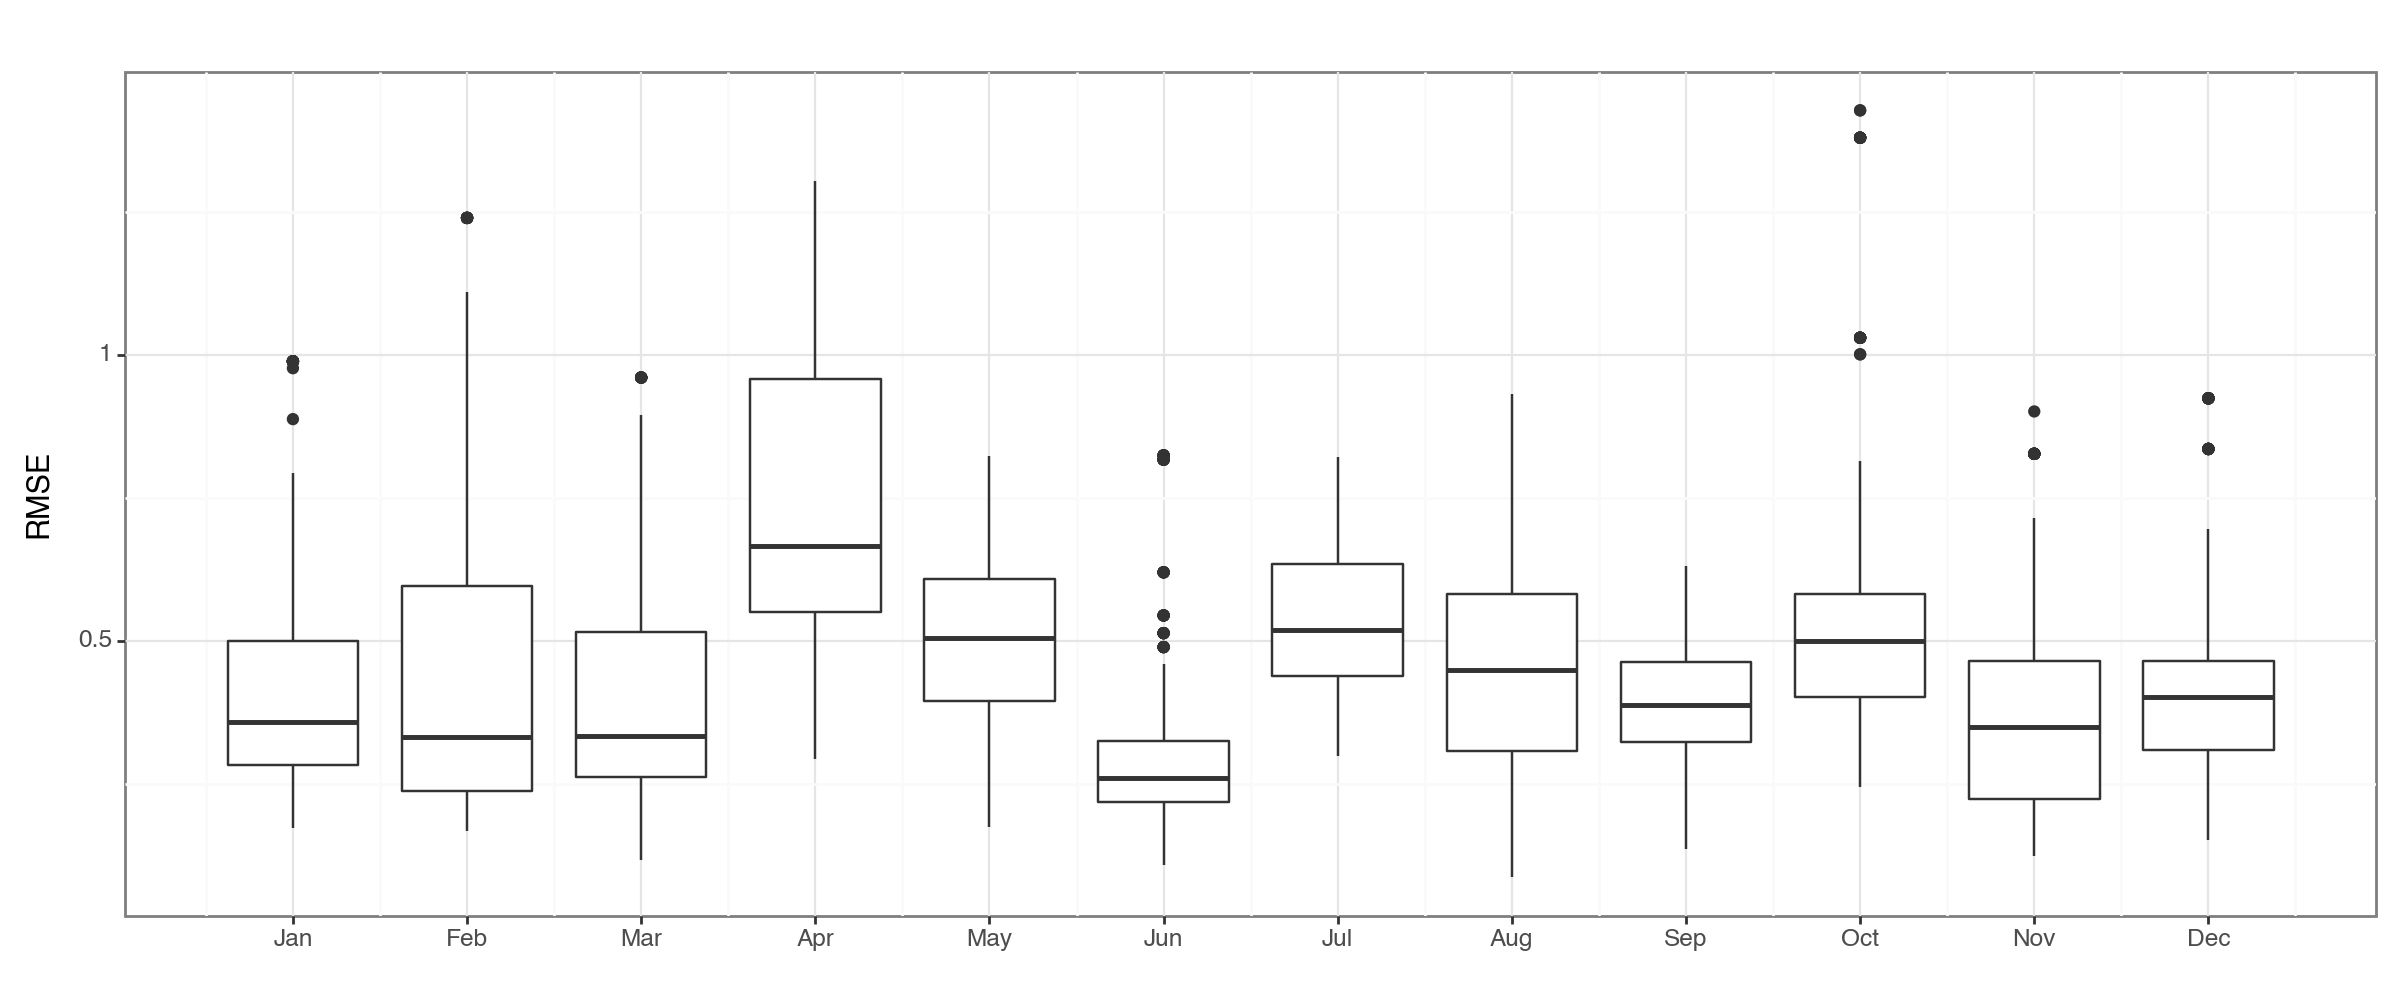

<Figure Size: (1200 x 500)>

In [23]:
rmse_df = test_preds.groupby([test_preds.Date.dt.month, "model", "lake", "steps_ahead"]).apply(
    summarize).reset_index()

ggplot(data=rmse_df, mapping=aes(x="Date", y="rmse", group="Date")) + geom_boxplot() + scale_x_continuous(
    breaks=np.arange(1, 13), labels=calendar.month_abbr[1:]) + theme_bw() + ylab("RMSE") + theme(
    axis_title_x=element_blank(), figure_size=(12, 5))


In [24]:
melted_data = test_preds.set_index(["Date", "lake", "model", "steps_ahead"]).melt(ignore_index=False)
transformed_data = [
    y_scaler.inverse_transform(
        df.reset_index().pivot(index=["Date", "model", "steps_ahead"], columns="lake", values="value")[
            ["sup", "mic_hur", "eri", "ont"]]).melt(
        ignore_index=False, value_name=grp[-1]).set_index("lake", append=True)
    for grp, df in melted_data.groupby(["variable"])
]

transformed_vals = pd.concat(transformed_data, axis=1).reset_index()

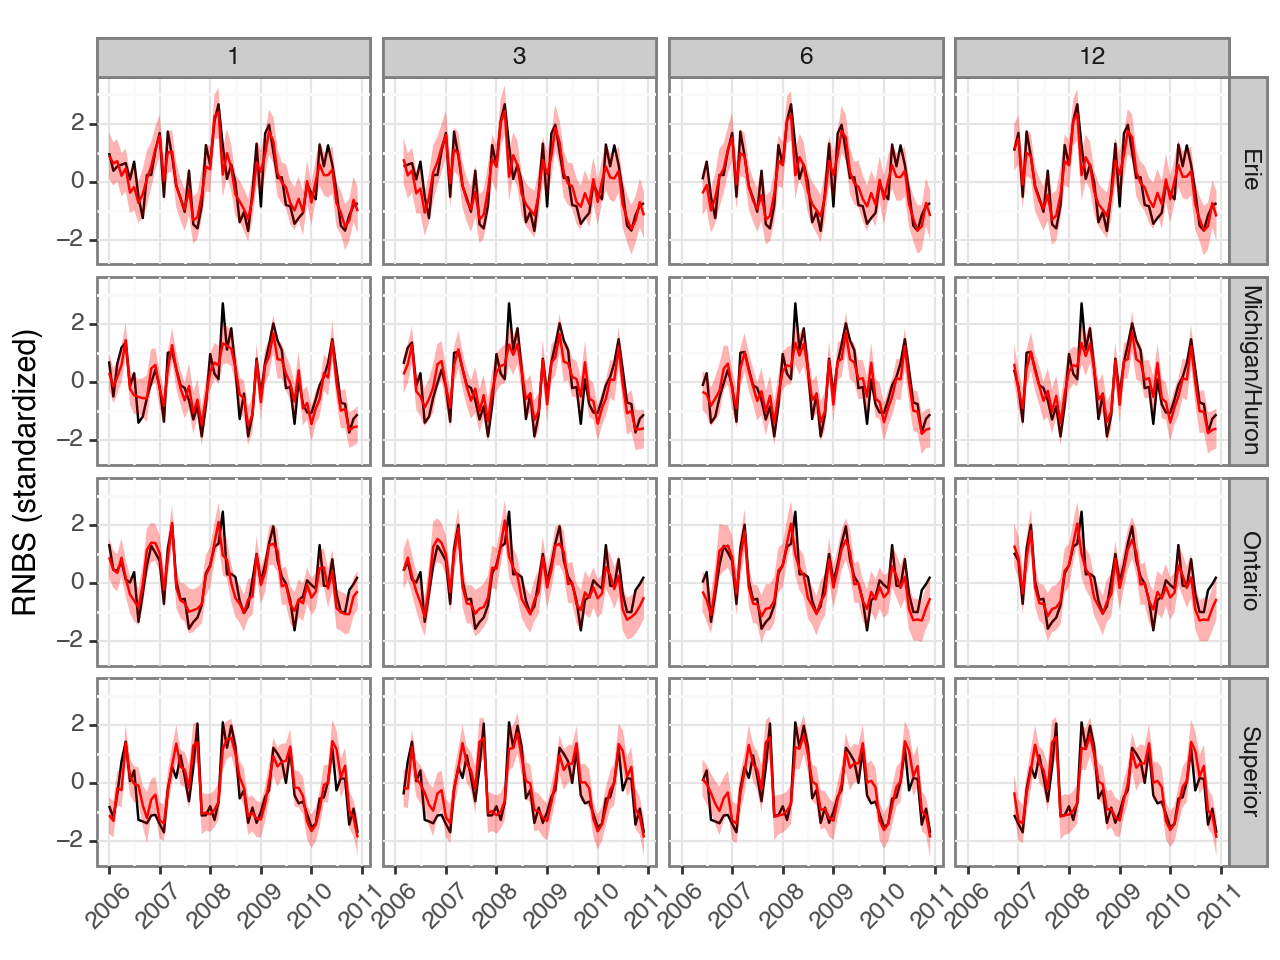

<Figure Size: (640 x 480)>

In [25]:
plot_data = test_preds[
    (test_preds["model"] == "NARX") & test_preds["steps_ahead"].isin([1, 3, 6, 12])]

(

        ggplot(data=plot_data, mapping=aes(x="Date", y="true")) +
        facet_grid("lake~steps_ahead", labeller=rename_lakes) +
        geom_line() +
        geom_line(mapping=aes(y="mean"), color="red") +
        theme_bw() +
        geom_ribbon(aes(ymin="lower", ymax="upper", y="mean"), fill="red", alpha=0.3) +
        scale_x_datetime(
            limits=[plot_data.Date.min(), plot_data.Date.max()],
            labels=date_format(fmt="%Y"), breaks=date_breaks("1 year")
        ) +
        theme(axis_text_x=element_text(angle=45), axis_title_x=element_blank()) +
        ylab("RNBS (standardized)")

)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


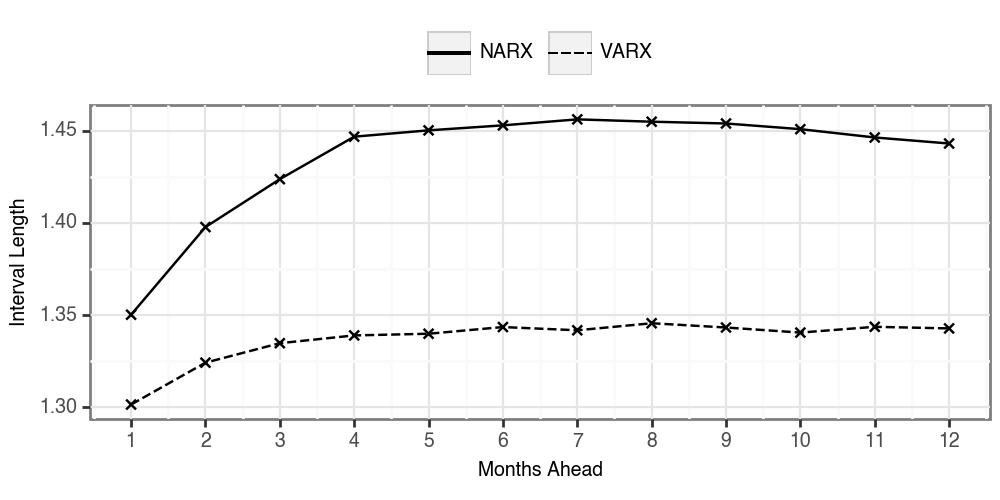

<Figure Size: (500 x 250)>

In [26]:
plot_data = test_preds.groupby(["model", "steps_ahead"]).apply(summarize).reset_index()
plot_data = plot_data[plot_data["model"].isin(["VARX", "NARX"])]

(
        ggplot(data=plot_data, mapping=aes(x="steps_ahead", y="interval_len", linetype="model"))
        + geom_line()
        + theme_bw()
        + geom_point(shape="x")
        + theme(legend_position="top", legend_title=element_blank(), figure_size=(5, 2.5), text=element_text(size=7))
        + scale_color_brewer(palette="Dark2",
                             type="qual",
                             name="Model")
        + scale_x_continuous(breaks=np.arange(1, 13))
        + ylab("Interval Length")
        + xlab("Months Ahead")
)

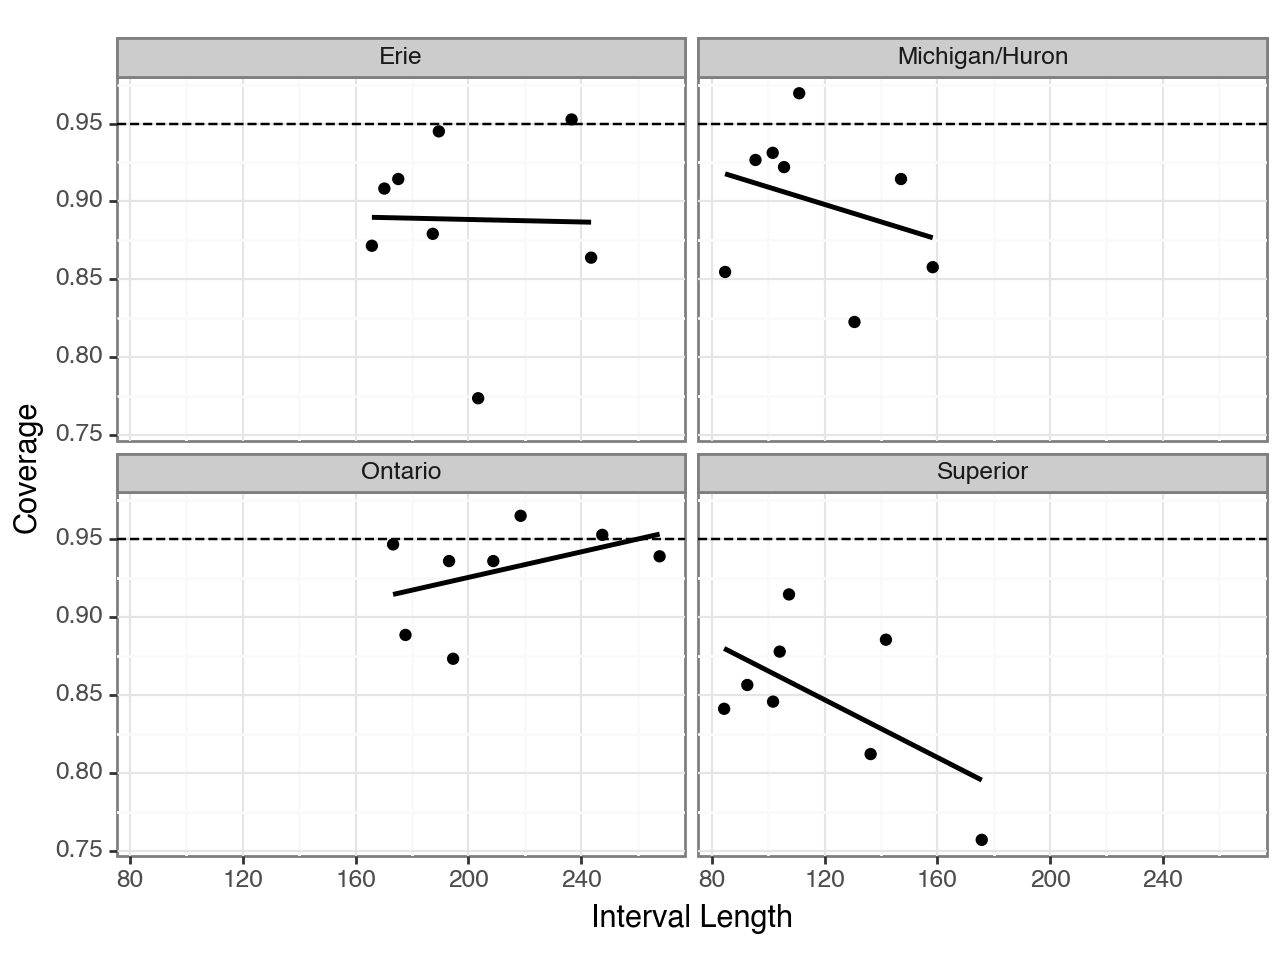

<Figure Size: (640 x 480)>

In [27]:
scatter_data = transformed_vals.groupby(["model", "lake"]).apply(summarize).reset_index()
scatter_data["method_type"] = np.where(scatter_data["model"].isin(["VARX", "NARX"]), "AR", "Non-AR")
(
        ggplot(data=scatter_data, mapping=aes(x="interval_len", y="coverage")) +
        geom_hline(yintercept=0.95, linetype='--') +
        geom_point() +
        geom_smooth(method="lm", se=False) +
        facet_wrap("~lake", nrow=2, labeller=rename_lakes) +
        theme_bw() +
        theme(legend_position="right", legend_title=element_blank()) +
        scale_color_brewer(palette="Dark2", type="qual", name="Method Type") +
        ylab("Coverage") +
        xlab("Interval Length")
)


In [28]:
from IPython.display import display_markdown

agg_values = ["coverage", "interval_len"]
lake_table = test_preds.groupby(["model", "lake"]).apply(summarize)[agg_values]

model_display_names = {
    "BoostedTrees": "Boosted Trees",
    "SimpleLM": "Linear Model",
    "Default": "Default Ensemble",
    "GP_Matern": "Gaussian Process",
    "MultitaskGP": "Multitask GP",
    "NARX": "NARX",
    "VARX": "VARX",
    "RF": "Random Forest"
}
lake_table.index = pd.MultiIndex.from_tuples(
    [(model_display_names[model], rename_lakes(lake)) for model, lake in lake_table.index], names=["model", "lake"])

lake_table = lake_table.melt(ignore_index=False).reset_index().pivot_table(index=["model", "variable"],
                                                                           columns=["lake"],
                                                                           values="value")

full_table = test_preds.groupby("model").apply(summarize)[agg_values]
full_table.index = pd.Index([model_display_names[model] for model in full_table.index], name="model")

full_table = full_table.melt(ignore_index=False).reset_index().assign(lake="All").pivot_table(
    index=["model", "variable"],
    columns=["lake"],
    values="value")
merged_table = lake_table.merge(full_table, left_index=True, right_index=True)

print(merged_table.melt(ignore_index=False).reset_index().pivot(index=["model"], columns=["lake", "variable"],
                                                                values="value").to_latex(float_format="%0.3f"))


\begin{tabular}{lrrrrrrrrrr}
\toprule
lake & \multicolumn{2}{r}{Erie} & \multicolumn{2}{r}{Michigan/Huron} & \multicolumn{2}{r}{Ontario} & \multicolumn{2}{r}{Superior} & \multicolumn{2}{r}{All} \\
variable & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
Boosted Trees & 0.774 & 1.868 & 0.823 & 1.839 & 0.873 & 1.574 & 0.757 & 2.557 & 0.807 & 1.960 \\
Default Ensemble & 0.864 & 2.236 & 0.858 & 2.229 & 0.939 & 2.167 & 0.812 & 1.984 & 0.868 & 2.154 \\
Gaussian Process & 0.908 & 1.563 & 0.969 & 1.563 & 0.936 & 1.563 & 0.914 & 1.563 & 0.932 & 1.563 \\
Linear Model & 0.945 & 1.740 & 0.931 & 1.430 & 0.965 & 1.768 & 0.846 & 1.480 & 0.922 & 1.605 \\
Multitask GP & 0.879 & 1.720 & 0.922 & 1.487 & 0.936 & 1.690 & 0.878 & 1.515 & 0.904 & 1.603 \\
NARX & 0.914 & 1.608 & 0.927 & 1.344 & 0.888 & 1.438 & 0.856 & 1.347 & 0.896 & 1.434 \\
Random Forest & 0.953 & 2.173 & 0.91

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


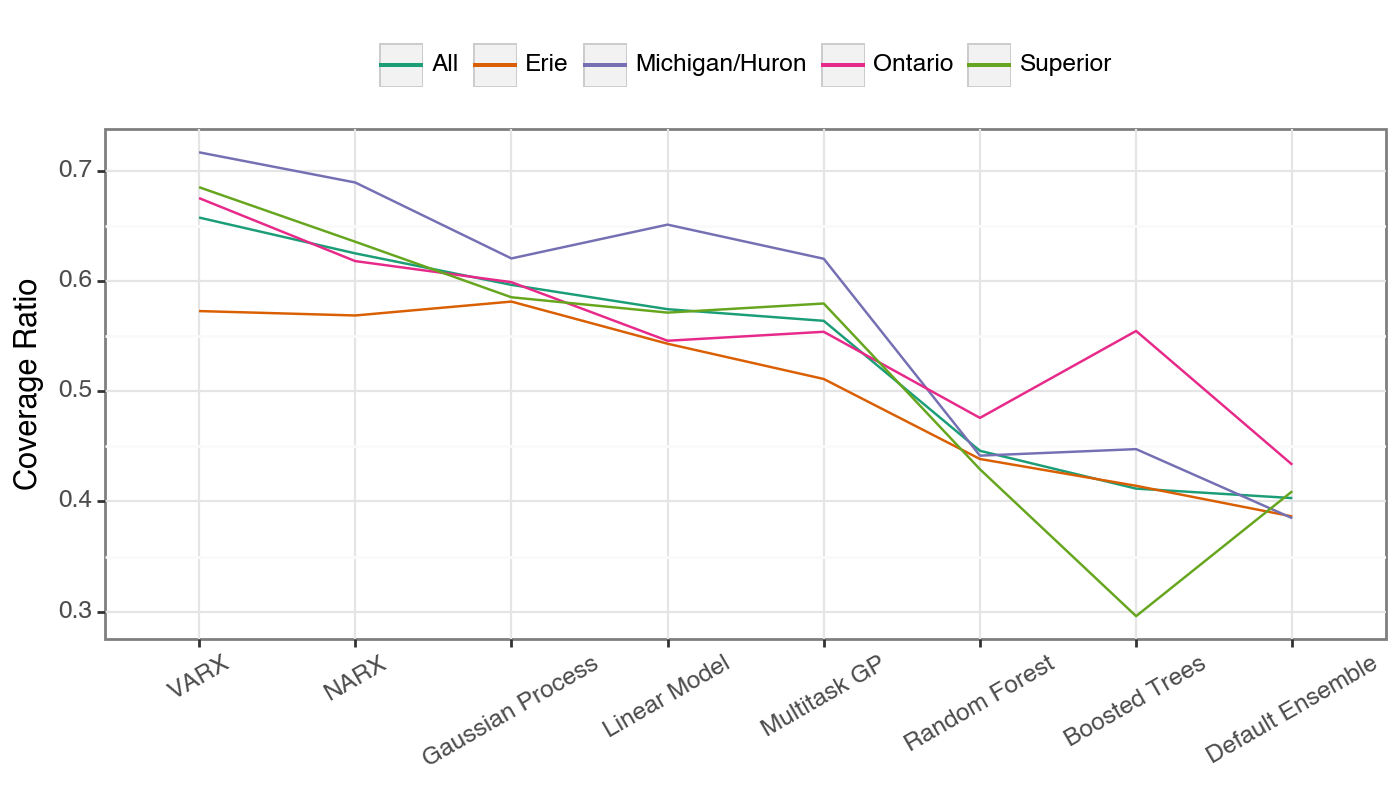

<Figure Size: (700 x 400)>

In [30]:
ratios = merged_table.melt(ignore_index=False).reset_index().pivot(columns=["variable"], index=["model", "lake"],
                                                                   values="value")
ratios["coverage_ratio"] = ratios["coverage"] / ratios["interval_len"]
plot_data = ratios.sort_values(["lake", "model"], ascending=False).reset_index()

(
        ggplot(data=plot_data,
               mapping=aes(x="reorder(model, -coverage_ratio)", y="coverage_ratio", group="lake",
                           color="lake"))
        + geom_line()
        + scale_color_brewer(palette="Dark2", type="qual")
        + theme_bw()
        + theme(axis_text_x=element_text(angle=30), axis_title_x=element_blank(), figure_size=(7, 4.0),
                legend_position="top", legend_title=element_blank())
        + ylab("Coverage Ratio")
    # + guides(color=guide_legend(title=element_blank()))
)



INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


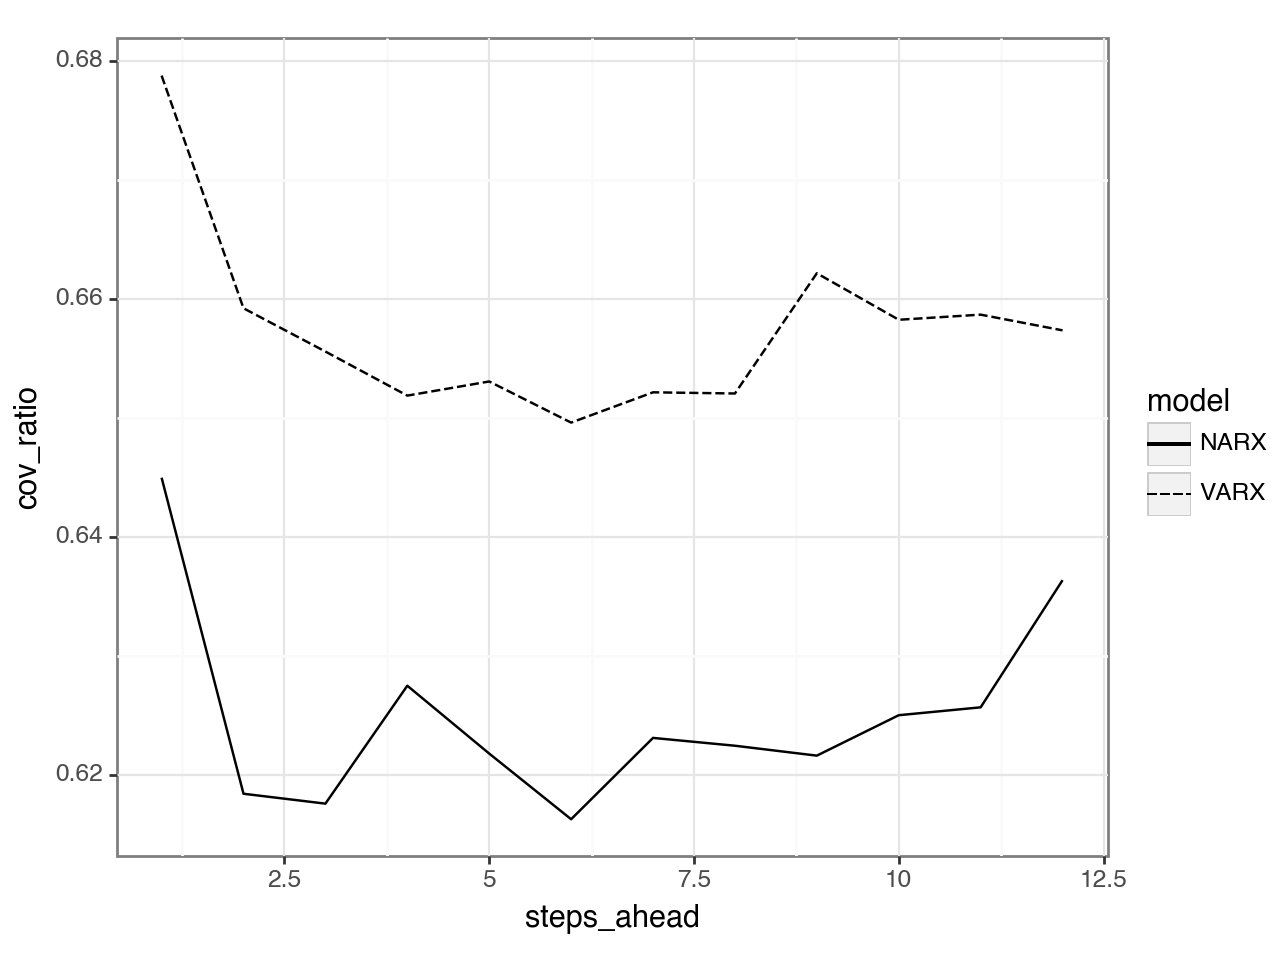

<Figure Size: (640 x 480)>

In [39]:
plot_data = test_preds[test_preds["model"].isin(["VARX", "NARX"])].groupby(["model", "steps_ahead"]).apply(
    summarize).reset_index()
plot_data["cov_ratio"] = plot_data["coverage"] / plot_data["interval_len"]

ggplot(data=plot_data, mapping=aes(x="steps_ahead", y="cov_ratio", linetype="model")) + geom_line() + theme_bw()